In [2]:
%%capture

!pip install tensorflow==2.11.0 --user

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.11.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/jupyter/.local/lib/python3.7/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [4]:
!ls

'Untitled Folder'	        generator_model.h5
 classifier_model.h5	        generator_model_0.h5
 classifier_model_0.h5	        generator_model_1.h5
 classifier_model_1.h5	        generator_model_2.h5
 classifier_model_2.h5	        generator_model_3.h5
 classifier_model_3.h5	        generator_model_4.h5
 classifier_model_4.h5	        generator_model_final.h5
 classifier_model_final.h5      generator_model_kaggle.h5
 discriminator_model.h5        'notebookd98e9b7b2f (2).ipynb'
 discriminator_model_0.h5       requirements.txt
 discriminator_model_1.h5       src
 discriminator_model_2.h5       test_notebook.ipynb
 discriminator_model_3.h5       tutorials
 discriminator_model_4.h5       untitled.txt
 discriminator_model_final.h5   wandb


In [5]:
from tensorflow.keras.layers import BatchNormalization, ReLU, Conv2D, Add, GlobalAveragePooling2D, Dense, Input, Conv2DTranspose, Reshape, Activation, Flatten, Embedding, Concatenate, AveragePooling2D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

2023-08-23 15:04:15.185714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 15:04:16.433931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-23 15:04:16.434097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: 

In [6]:
%%capture

!pip install tensorflow-gan
!pip install wandb
import tensorflow_gan as tfgan

In [8]:
!pip freeze > requirements.txt


In [9]:
NUM_EPOCHS = 5
BUFFER_SIZE = 60000
BATCH_SIZE = 2


In [10]:
num_classes = 10

In [11]:
(train_imgs, train_labels), (test_imgs, test_labels) = cifar10.load_data()

In [12]:
print(train_imgs.shape, test_imgs.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [13]:
random_indices_for_test = np.random.choice(len(test_imgs), size=1000, replace=False)

# Select random images and labels
random_test_imgs = test_imgs[random_indices_for_test]
random_test_labels = test_labels[random_indices_for_test]

In [14]:
resized_test_images = tf.image.resize(random_test_imgs, [256, 256])

2023-08-23 15:04:41.013333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-23 15:04:41.025295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-23 15:04:41.026970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-23 15:04:41.029531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

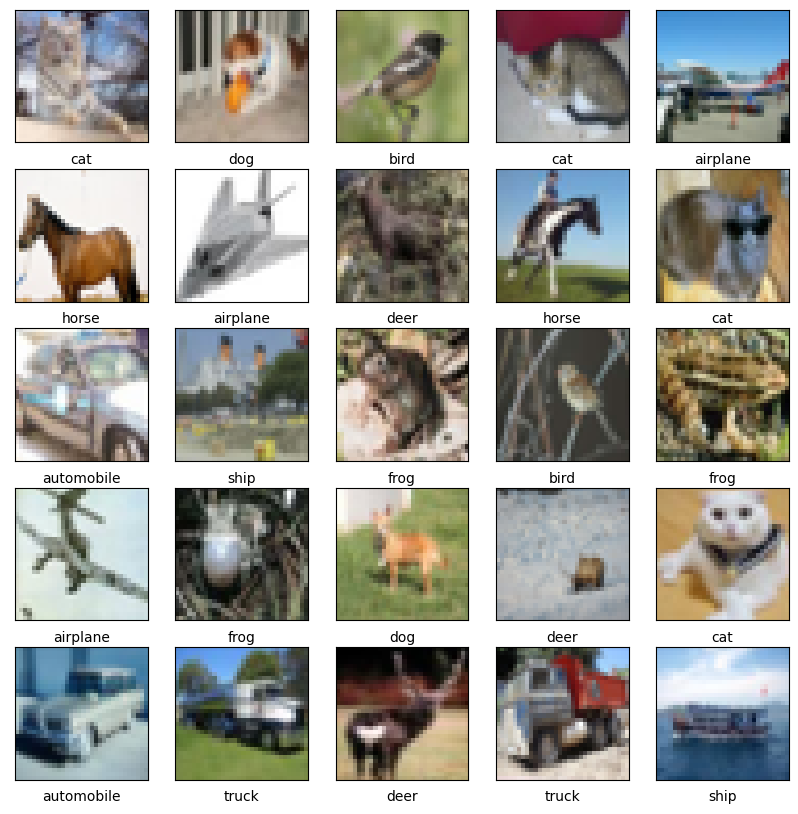

In [15]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))

for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(random_test_imgs[i])
  plt.xlabel(class_names[random_test_labels[i][0]])

plt.show()

In [16]:
#normalize resized images
#normalized_resized_images = resized_images / 255.0

In [17]:
#test_images = resized_test_images / 255.0

In [18]:
test_labels = tf.keras.utils.to_categorical(random_test_labels, num_classes)

In [19]:
test_dataset = tf.data.Dataset.from_tensor_slices((resized_test_images, test_labels)).batch(BATCH_SIZE)

In [20]:
print(test_dataset
     )

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [21]:
def classifier():
  base_model = ResNet50(
      input_shape=(256, 256, 3),
      include_top = False,
      weights = 'imagenet'
  )

  x = base_model.output
  x = GlobalAveragePooling2D()(x)

  number_of_classes = 10

  # multilayer perceptron with 2 residual blocks and skip connections
  shortcut = x


  x = Dense(512, activation='relu')(x)
  x = Dense(2048, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  x = Concatenate()([x, shortcut])

  shortcut = x

  x = Dense(512, activation='relu')(x)
  x = Dense(2048, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  x = Concatenate()([x, shortcut])

  preds = Dense(number_of_classes, activation="softmax")(x)

  #create model for classifier

  model = Model(inputs=base_model.input, outputs=preds)

  return model



In [22]:
classifier = classifier()

In [23]:
def orthogonal_regularizer(scale) :
  """ Defining the Orthogonal regularizer and return the function at last to be used in Conv layer as kernel regularizer"""

  def ortho_reg(w) :
      """ Reshaping the matrxi in to 2D tensor for enforcing orthogonality"""
      _, _, _, c = w.get_shape().as_list()

      w = tf.reshape(w, [-1, c])

      """ Declaring a Identity Tensor of appropriate size"""
      identity = tf.eye(c)

      """ Regularizer Wt*W - I """
      w_transpose = tf.transpose(w)
      w_mul = tf.matmul(w_transpose, w)
      reg = tf.subtract(w_mul, identity)

      """Calculating the Loss Obtained"""
      ortho_loss = tf.nn.l2_loss(reg)

      return scale * ortho_loss

  return ortho_reg

In [24]:
from keras.layers.pooling.max_pooling2d import MaxPooling2D
weight_init = tf.initializers.truncated_normal(mean=0.0, stddev=0.02)
weight_regularizer = orthogonal_regularizer(0.0001)


def global_sum_pooling(x) :
    gsp = tf.reduce_sum(x, axis=[1, 2], keepdims=True)
    return gsp

def max_pooling(x) :
    x = MaxPooling2D(pool_size=2, strides=2, padding='SAME')(x)
    return x

def hw_flatten(x) :
    return tf.reshape(x, shape=[x.shape[0], -1, x.shape[-1]])


def _l2normalize(v, eps=1e-12):
  """l2 normize the input vector."""
  return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)

def spectral_normalization(name, weights, num_iters=1, update_collection=None,
                           with_sigma=False):
  w_shape = weights.shape.as_list()
  w_mat = tf.reshape(weights, [-1, w_shape[-1]])  # [-1, output_channel]
  u = tf.compat.v1.get_variable(name + 'u', [1, w_shape[-1]],
                      initializer=tf.keras.initializers.TruncatedNormal(),
                      trainable=False)
  u_ = u
  for _ in range(num_iters):
    v_ = _l2normalize(tf.matmul(u_, w_mat, transpose_b=True))
    u_ = _l2normalize(tf.matmul(v_, w_mat))

  sigma = tf.squeeze(tf.matmul(tf.matmul(v_, w_mat), u_, transpose_b=True))
  w_mat /= sigma
  if update_collection is None:
    with tf.control_dependencies([u.assign(u_)]):
      w_bar = tf.reshape(w_mat, w_shape)
  else:
    w_bar = tf.reshape(w_mat, w_shape)
    if update_collection != 'NO_OPS':
      tf.add_to_collection(update_collection, u.assign(u_))
  if with_sigma:
    return w_bar, sigma
  else:
    return w_bar

def conv(name, inputs, nums_out, k_size, strides, update_collection=None, is_sn=False):
    nums_in = inputs.shape[-1]
    with tf.name_scope(name):
        W = tf.compat.v1.get_variable("W", [k_size, k_size, nums_in, nums_out], initializer=tf.keras.initializers.Orthogonal())
        b = tf.compat.v1.get_variable("b", [nums_out], initializer=tf.constant_initializer([0.0]))
        if is_sn:
            W = spectral_normalization("sn", W, update_collection=update_collection)
        con = tf.nn.conv2d(inputs, W, [1, strides, strides, 1], "SAME")
    return tf.nn.bias_add(con, b)


def inner_product(global_pooled, y, nums_class, update_collection=None):
    W = global_pooled.shape[-1]
    V = tf.compat.v1.get_variable("V", [nums_class, W], initializer=tf.orthogonal_initializer())
    V = tf.transpose(V)
    V = spectral_normalization("embed", V, update_collection=update_collection)
    V = tf.transpose(V)
    temp = tf.nn.embedding_lookup(V, y)
    temp = tf.reduce_sum(temp * global_pooled, axis=1, keep_dims=True)
    return temp


In [25]:
def non_local(name, inputs, update_collection, is_sn):
    h, w, num_channels = inputs.shape[1], inputs.shape[2], inputs.shape[3]
    location_num = h * w
    downsampled_num = location_num // 4
    with tf.name_scope(name):
        theta = conv("f", inputs, num_channels // 8, 1, 1, update_collection, is_sn)
        theta = tf.reshape(theta, [-1, location_num, num_channels // 8])
        phi = conv("h", inputs, num_channels // 8, 1, 1, update_collection, is_sn)
        phi = AveragePooling2D()(phi)
        phi = tf.reshape(phi, [-1, downsampled_num, num_channels // 8])
        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)
        g = conv("g", inputs, num_channels // 2, 1, 1, update_collection, is_sn)
        g = AveragePooling2D()(g)
        g = tf.reshape(g, [-1, downsampled_num, num_channels // 2])
        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, [-1, h, w, num_channels // 2])
        sigma = tf.compat.v1.get_variable("sigma_ratio", [], initializer=tf.constant_initializer(0.0))
        attn_g = conv("attn", attn_g, num_channels, 1, 1, update_collection, is_sn)
        return inputs + sigma * attn_g

In [26]:
def generator_residual_block(input_tensor, filters):
  shortcut = input_tensor

  x = BatchNormalization()(input_tensor)
  x = ReLU()(x)
  x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

  shortcut = Conv2D(filters, kernel_size=(3, 3), padding='same')(shortcut)

  #add shortcut to 2nd convolutional layer
  x = shortcut + x

  return x

In [27]:
def generator_network():
  z_dim = 128
  channel_width_multiplier = 128
  number_of_classes = 10

  # z: input noise vector, y: embedding
  z_input, y_input = Input(shape=(z_dim,)), Input(shape=(number_of_classes,))

  input_concat = Concatenate()([z_input, y_input])
  #generator layers
  #TODO: use a loop to clean up code

  ch = channel_width_multiplier * 16

  x = Dense(4 * 4 * ch, activation='relu')(input_concat)
  print("shape", x.shape)
  x = tf.keras.layers.Reshape((4, 4, ch))(x)

  print(x.shape)
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)
  ch = ch // 2
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)
  ch = ch // 2
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)
  ch = ch // 2
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)

  #TODO: Add Non-Local Block
  x = non_local("Non-Local", x, None, True)

  ch = ch // 2
  x = generator_residual_block(x, filters=ch)
  x = Conv2DTranspose(ch, kernel_size=(3,3), strides=(2,2), padding='same')(x)

  print(x.shape)

  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(3, kernel_size=3, padding='same', activation='tanh')(x)
    
  print(x.shape)  

  model = tf.keras.models.Model(inputs=[z_input, y_input], outputs=x)

  return model



In [28]:
generator = generator_network()

shape (None, 32768)
(None, 4, 4, 2048)
(None, 8, 8, 2048)
(None, 16, 16, 1024)
(None, 32, 32, 1024)
(None, 64, 64, 512)
(None, 128, 128, 256)
(None, 256, 256, 128)
(None, 256, 256, 3)


2023-08-23 15:05:43.477728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


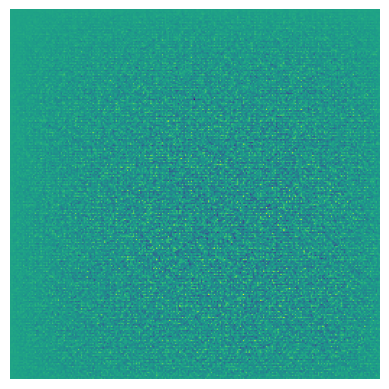

In [29]:
z_dim = 128
num_classes = 10
z = np.random.normal(size=(1, z_dim))
y = np.random.randint(0, num_classes, size=(1, num_classes))

generated_image = generator([z, y], training=False)


# Display the generated image
plt.imshow(generated_image[0, :, :, 0])
plt.axis('off')
plt.show()


In [30]:
def discriminator_residual_block(input_tensor, filters):
  shortcut = input_tensor

  x = ReLU()(input_tensor)

  x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

  x = ReLU()(x)

  x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

  #add shortcut to 2nd convolutional layer

  shortcut = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)

  return x + shortcut

In [31]:
from keras.layers.pooling.average_pooling2d import AveragePooling2D
def discriminator_network():
  input_shape = (256, 256, 3)
  channel_width_multiplier = 128
  num_classes = 10

  # Input layer
  input_image = Input(shape=input_shape)

  x = discriminator_residual_block(input_image, 3)  # ResBlock down: 3 -> ch
  print(x.shape)

  ch = channel_width_multiplier

  x = discriminator_residual_block(x, ch)  # ResBlock down: ch -> ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  #TODO: Add Non-Local Block              Non-Local Block
  x = non_local("Non-Local", x, None, True)

  x = discriminator_residual_block(x, ch)  # ResBlock down: ch -> 2 . ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  ch*=2
  x = discriminator_residual_block(x, ch)  # ResBlock down: 2 . ch -> 4 . ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  ch*=2
  x = discriminator_residual_block(x, ch)  # ResBlock down: 4 . ch -> 8 . ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  ch *=2
  x = discriminator_residual_block(x, ch)  # ResBlock down: 8 . ch -> 16 . ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  ch *=2
  x = discriminator_residual_block(x, ch)  # ResBlock down: 16 . ch -> 16 . ch
  x = Conv2D(ch, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  print(x.shape)

  x = ReLU()(x)
  x = global_sum_pooling(x)
  print(x.shape)

  class_labels = Input(shape=(10,))
  h = Dense(1)(class_labels)

  x = Flatten()(x)

  x = Concatenate()([x, h])

  output = Dense(1)(x)
  print(output.shape)


  model = Model(inputs=[input_image, class_labels], outputs=output)

  return model

In [32]:
discriminator = discriminator_network()

(None, 256, 256, 3)
(None, 128, 128, 128)
(None, 64, 64, 128)
(None, 32, 32, 256)
(None, 16, 16, 512)
(None, 8, 8, 1024)
(None, 4, 4, 2048)
(None, 1, 1, 2048)
(None, 1)


In [33]:
generator_optimizer = Adam(learning_rate=0.00005, beta_1=0, beta_2=0.999)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0, beta_2=0.999)
classifier_optimizer = Adam(learning_rate=0.0002, beta_1=0, beta_2=0.999)

In [34]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def calculate_classifier_loss(true_labels, predicted_labels):
  loss = tf.keras.losses.categorical_crossentropy(true_labels, predicted_labels)
  return loss

def calculate_generator_loss(fake_output):
  loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output)

  return loss

def calculate_discriminator_loss(real_output, fake_output):
  real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)

  return real_loss + fake_loss

In [35]:
classifier.compile(optimizer=classifier_optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
generator.compile(optimizer=generator_optimizer, )
discriminator.compile(optimizer=discriminator_optimizer,)

In [36]:
!ls

'Untitled Folder'	        generator_model.h5
 classifier_model.h5	        generator_model_0.h5
 classifier_model_0.h5	        generator_model_1.h5
 classifier_model_1.h5	        generator_model_2.h5
 classifier_model_2.h5	        generator_model_3.h5
 classifier_model_3.h5	        generator_model_4.h5
 classifier_model_4.h5	        generator_model_final.h5
 classifier_model_final.h5      generator_model_kaggle.h5
 discriminator_model.h5        'notebookd98e9b7b2f (2).ipynb'
 discriminator_model_0.h5       requirements.txt
 discriminator_model_1.h5       src
 discriminator_model_2.h5       test_notebook.ipynb
 discriminator_model_3.h5       tutorials
 discriminator_model_4.h5       untitled.txt
 discriminator_model_final.h5   wandb


In [37]:
generator.load_weights("generator_model_kaggle.h5")

In [38]:
discriminator.load_weights("discriminator_model.h5")

In [50]:
classifier_weights = ['classifier_model_kaggle.h5', 'classifier_model_0.h5', 'classifier_model_1.h5', 'classifier_model_2.h5', 'classifier_model_3.h5', 'classifier_model_4.h5']
for weight in classifier_weights:
    classifier.load_weights(weight)
    print(f"Weight: {weight}")
    loss, acc = classifier.evaluate(test_dataset)
    print("\n\n")


Weight: classifier_model_kaggle.h5
500/500 [==============================] - 7s 15ms/step - loss: 8.4129 - accuracy: 0.3610



Weight: classifier_model_0.h5
500/500 [==============================] - 7s 14ms/step - loss: 2.3901 - accuracy: 0.4610



Weight: classifier_model_1.h5
500/500 [==============================] - 7s 15ms/step - loss: 1.1101 - accuracy: 0.6840



Weight: classifier_model_2.h5
500/500 [==============================] - 7s 15ms/step - loss: 1.2933 - accuracy: 0.6670



Weight: classifier_model_3.h5
500/500 [==============================] - 7s 15ms/step - loss: 1.4290 - accuracy: 0.6960



Weight: classifier_model_4.h5
500/500 [==============================] - 7s 15ms/step - loss: 1.9388 - accuracy: 0.6870





In [51]:
def generate_fake_images(num_images):
    noise = tf.random.normal([num_images, z_dim])
    random_labels = tf.random.uniform([num_images], minval=0, maxval=num_classes, dtype=tf.int32)
    class_embeddings = tf.one_hot(random_labels, depth=num_classes)
    fake_images = generator([noise, class_embeddings], training=False)
    return fake_images

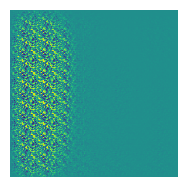

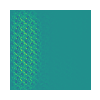

In [52]:
images = generate_fake_images(2)
fig = plt.figure(figsize=(10, 10))

for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i, :, :, 0])
    plt.axis('off')
    plt.show()


In [53]:
@tf.function
def get_fid_score(real_image, gen_image):
    print(real_image.shape)
    size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE
    #resized_real_images = tf.image.resize(real_image, [256, 256], method=tf.image.ResizeMethod.BILINEAR)
    #resized_generated_images = tf.image.resize(gen_image, [256, 256], method=tf.image.ResizeMethod.BILINEAR)
    num_inception_images = 1
    num_batches = BATCH_SIZE // num_inception_images
    
    fid = tfgan.eval.frechet_inception_distance(real_image, gen_image, num_batches=num_batches)
    
    return fid

In [ ]:
generator_weights = ['generator_model_kaggle.h5', 'generator_model_0.h5', 'generator_model_1.h5', 'generator_model_2.h5', 'generator_model_3.h5', 'generator_model_4.h5']


for weight in generator_weights:
    generator.load_weights(weight)
    fid_scores = []
    for batch_images, batch_labels in test_dataset:
        gen_images = generate_fake_images(batch_images.shape[0])
        fid_score = get_fid_score(batch_images, images)
        fid_scores.append(fid_score)
        
    print(f'Weight: {weight}')
    print(f'FID Score: {np.mean(fid_scores)}')
    print('\n\n')
    
    
    

2023-08-23 15:33:13.059195: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-23 15:33:13.061317: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-23 15:33:13.062154: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-23 15:33:23.064478: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU

ResourceExhaustedError: Exception encountered when calling layer 'conv2d_transpose_2' (type Conv2DTranspose).

{{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1000,1024,33,33] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput]

Call arguments received by layer 'conv2d_transpose_2' (type Conv2DTranspose):
  • inputs=tf.Tensor(shape=(1000, 16, 16, 1024), dtype=float32)

In [ ]:
@tf.function
def get_inception_score(images, gen, num_inception_images = 8):
    size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE
    #resized_images = tf.image.resize(images, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    num_batches = BATCH_SIZE // num_inception_images
    
    inc_score = tfgan.eval.inception_score(images, num_batches=num_batches)
    
    return inc_score

In [ ]:
is_scores = []
for batch_images, batch_labels in test_dataset:
    is_score = get_inception_score(batch_images, images)
    is_scores.append(is_score)
    
print(f"Average FID Score: {np.mean(fid_scores)}")

In [ ]:
!ls

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('requirements.txt')